# 三层神经网络实验报告

## 1. 实验概述

本实验实现了一个三层神经网络模型，用于CIFAR-10图像分类任务。实验的主要目标是：

1. 从零开始实现一个三层神经网络
2. 在CIFAR-10数据集上训练和评估模型
3. 可视化训练过程和模型参数
4. 分析模型性能和参数特征

## 2. 导入必要的库

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sys

from model import ThreeLayerNet
from losses import get_loss
from optimizer import get_optimizer, get_scheduler
from train import train_model
from evaluation import load_and_test, evaluate_model_classes
from utils import download_cifar10, load_cifar10, preprocess_data, visualize_sample, plot_training_history
from config import DEFAULT_CONFIG, SEARCH_CONFIG, CIFAR10_CLASSES
from visualize_weights import visualize_weights, visualize_weight_distributions

## 3. 模型架构介绍

本实验实现的是一个三层神经网络，包括：

- **输入层**：接收CIFAR-10图像数据，维度为3072（32×32×3）
- **第一隐藏层**：默认包含512个神经元，使用ReLU激活函数
- **第二隐藏层**：默认包含256个神经元，使用ReLU激活函数
- **输出层**：包含10个神经元（对应CIFAR-10的10个类别），使用Softmax激活函数

模型的前向传播过程如下：

1. 输入层接收图像数据 X
2. 第一隐藏层计算：$Z_1 = X \cdot W_1 + b_1$，然后应用激活函数：$A_1 = ReLU(Z_1)$
3. 第二隐藏层计算：$Z_2 = A_1 \cdot W_2 + b_2$，然后应用激活函数：$A_2 = ReLU(Z_2)$
4. 输出层计算：$Z_3 = A_2 \cdot W_3 + b_3$，然后应用激活函数：$A_3 = Softmax(Z_3)$

模型使用交叉熵损失函数，并通过反向传播算法计算梯度，使用随机梯度下降（SGD）优化器更新参数。

## 4. 数据集介绍

CIFAR-10是一个包含60,000张32×32彩色图像的数据集，分为10个类别，每个类别6,000张图像。数据集分为50,000张训练图像和10,000张测试图像。

10个类别分别是：飞机、汽车、鸟、猫、鹿、狗、青蛙、马、船和卡车。

在本实验中，我们将训练集进一步分为训练集和验证集，比例为9:1。

In [2]:
# 加载CIFAR-10数据集
data_dir = 'data'
X_train, y_train, X_test, y_test = load_cifar10(os.path.join(data_dir, 'cifar-10-batches-py'))
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data(X_train, y_train, X_test, y_test)

# 显示数据集信息
print(f'训练集大小: {X_train.shape[0]} 样本')
print(f'验证集大小: {X_val.shape[0]} 样本')
print(f'测试集大小: {X_test.shape[0]} 样本')
print(f'图像维度: {X_train.shape[1]} 特征')

训练集大小: 45000 样本
验证集大小: 5000 样本
测试集大小: 10000 样本
图像维度: 3072 特征


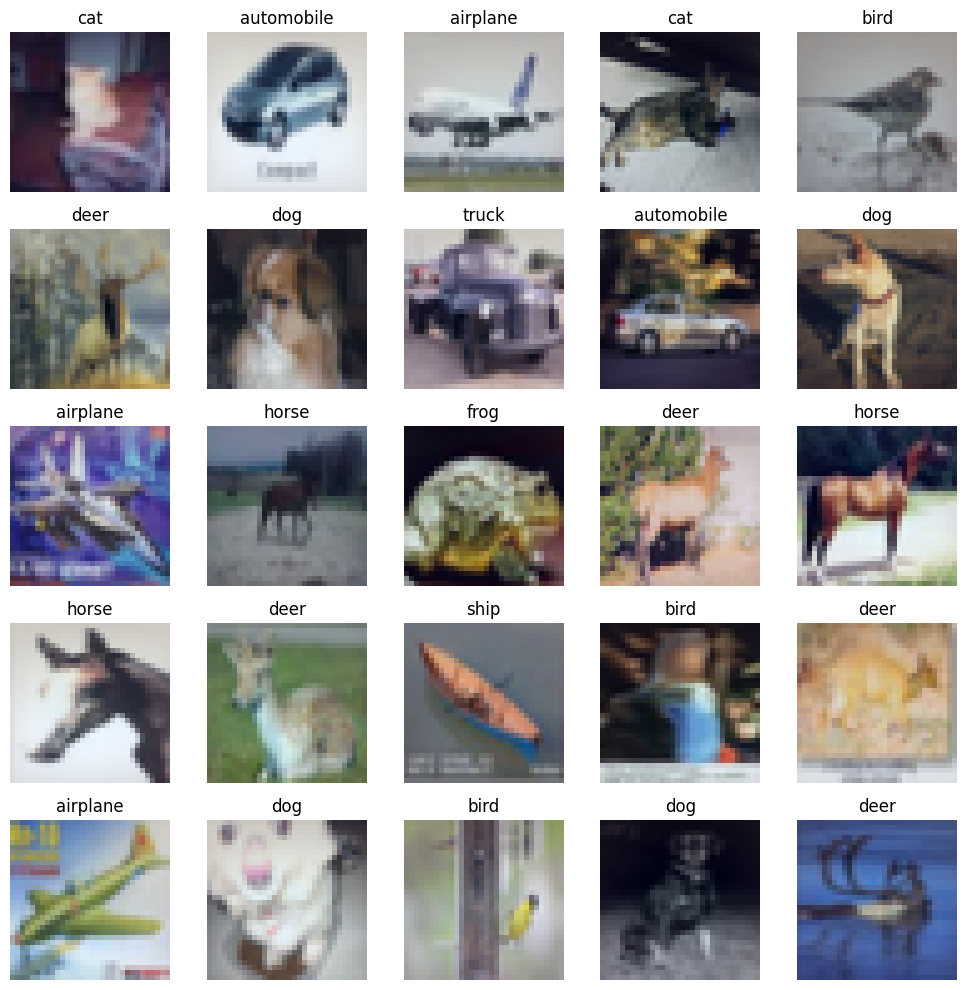

In [3]:
# 可视化数据集样本
visualize_sample(X_train[:25], y_train[:25], CIFAR10_CLASSES)

## 5. 超参数设置

本实验使用的默认超参数设置如下：

In [4]:
# 显示默认超参数设置
for key, value in DEFAULT_CONFIG.items():
    if key not in ['input_size', 'output_size', 'data_dir', 'model_dir', 'results_dir']:
        print(f'{key}: {value}')

hidden_size1: 512
hidden_size2: 256
hidden_activation: relu
output_activation: softmax
loss: cross_entropy
optimizer: sgd
learning_rate: 0.2
momentum: 0.9
weight_decay: 0.0001
batch_size: 256
epochs: 25
scheduler: step
scheduler_params: {'step_size': 1, 'gamma': 0.98}
validation_split: 0.1


## 6. 模型训练与评估

下面我们将使用默认配置训练模型，并记录训练过程中的损失和准确率。

In [5]:
# 创建训练配置
config = DEFAULT_CONFIG.copy()
config.update({
    'X_train': X_train,
    'y_train': y_train,
    'X_val': X_val,
    'y_val': y_val,
    'epochs': 25  # 可以根据需要调整训练轮数
})

# 训练模型
print('开始训练模型...')
model, history = train_model(config)
print('模型训练完成！')

开始训练模型...
Epoch 1/25 - 保存最佳模型，验证准确率: 0.3759
Epoch 1/25 - 耗时: 12.85s - 学习率: 0.200000
  训练损失: 1.9884 - 训练准确率: 0.3088
  验证损失: 1.7710 - 验证准确率: 0.3759
Epoch 2/25 - 保存最佳模型，验证准确率: 0.4107
Epoch 2/25 - 耗时: 12.08s - 学习率: 0.196000
  训练损失: 1.6901 - 训练准确率: 0.4082
  验证损失: 1.6785 - 验证准确率: 0.4107
Epoch 3/25 - 保存最佳模型，验证准确率: 0.4270
Epoch 3/25 - 耗时: 11.94s - 学习率: 0.192080
  训练损失: 1.5984 - 训练准确率: 0.4452
  验证损失: 1.6301 - 验证准确率: 0.4270
Epoch 4/25 - 保存最佳模型，验证准确率: 0.4432
Epoch 4/25 - 耗时: 12.73s - 学习率: 0.188238
  训练损失: 1.5439 - 训练准确率: 0.4678
  验证损失: 1.5957 - 验证准确率: 0.4432
Epoch 5/25 - 耗时: 12.30s - 学习率: 0.184474
  训练损失: 1.5051 - 训练准确率: 0.4839
  验证损失: 1.5743 - 验证准确率: 0.4420
Epoch 6/25 - 保存最佳模型，验证准确率: 0.4561
Epoch 6/25 - 耗时: 12.49s - 学习率: 0.180784
  训练损失: 1.4765 - 训练准确率: 0.4945
  验证损失: 1.5499 - 验证准确率: 0.4561
Epoch 7/25 - 保存最佳模型，验证准确率: 0.4618
Epoch 7/25 - 耗时: 11.88s - 学习率: 0.177168
  训练损失: 1.4551 - 训练准确率: 0.5042
  验证损失: 1.5407 - 验证准确率: 0.4618
Epoch 8/25 - 保存最佳模型，验证准确率: 0.4645
Epoch 8/25 - 耗时: 11.91s - 学习率: 0.17362

## 7. 训练过程可视化

### 7.1 训练集和验证集上的损失曲线

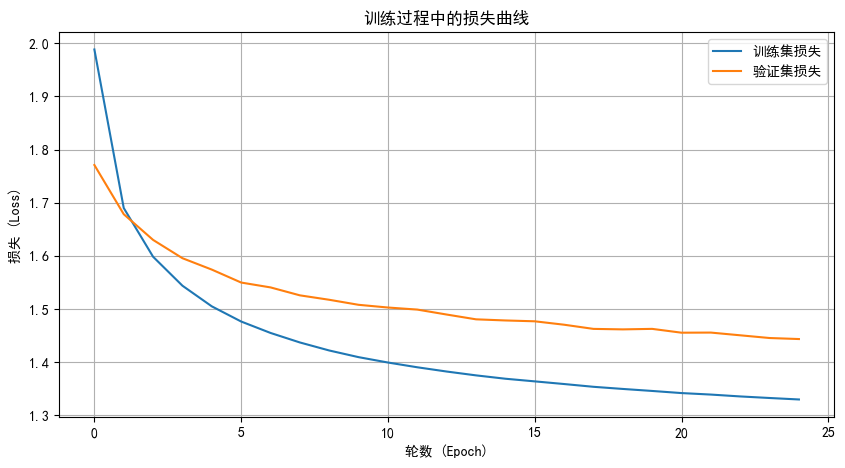

In [29]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置默认字体为黑体
# 绘制损失曲线
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='训练集损失')
plt.plot(history['val_loss'], label='验证集损失')
plt.xlabel('轮数 (Epoch)')
plt.ylabel('损失 (Loss)')
plt.legend()
plt.title('训练过程中的损失曲线')
plt.grid(True)
plt.show()

### 7.2 训练集和验证集上的准确率曲线

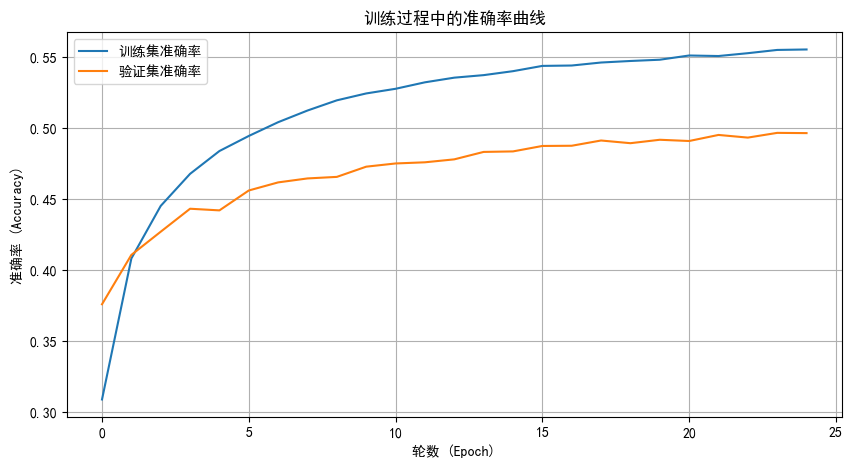

In [30]:
# 绘制准确率曲线
plt.figure(figsize=(10, 5))
plt.plot(history['train_acc'], label='训练集准确率')
plt.plot(history['val_acc'], label='验证集准确率')
plt.xlabel('轮数 (Epoch)')
plt.ylabel('准确率 (Accuracy)')
plt.legend()
plt.title('训练过程中的准确率曲线')
plt.grid(True)
plt.show()

### 7.3 学习率变化曲线

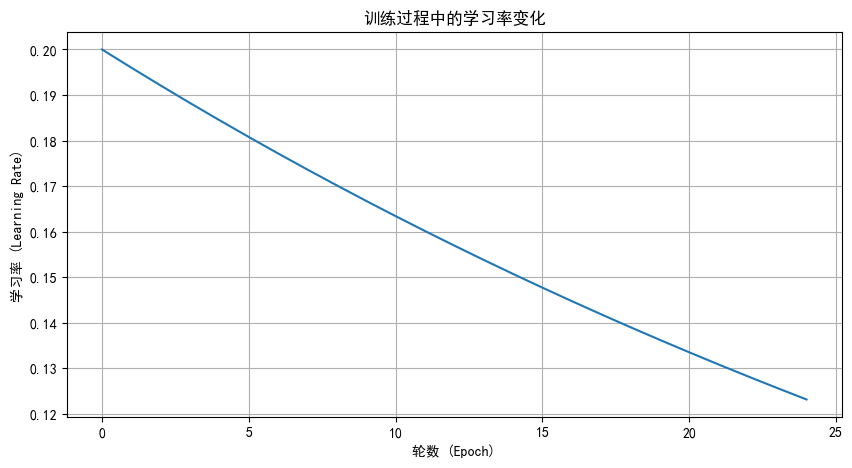

In [31]:
# 绘制学习率变化曲线
plt.figure(figsize=(10, 5))
plt.plot(history['lr'])
plt.xlabel('轮数 (Epoch)')
plt.ylabel('学习率 (Learning Rate)')
plt.title('训练过程中的学习率变化')
plt.grid(True)
plt.show()

## 8. 模型在测试集上的性能

In [12]:
# 在测试集上评估模型
y_pred = model.predict(X_test)
test_acc = np.mean(y_pred == y_test)
print(f'测试集准确率: {test_acc:.4f}')

测试集准确率: 0.5056


各类别准确率:
  airplane: 0.5440
  automobile: 0.6370
  bird: 0.3100
  cat: 0.3610
  deer: 0.3900
  dog: 0.3900
  frog: 0.5690
  horse: 0.5760
  ship: 0.6890
  truck: 0.5900


TypeError: unhashable type: 'dict'

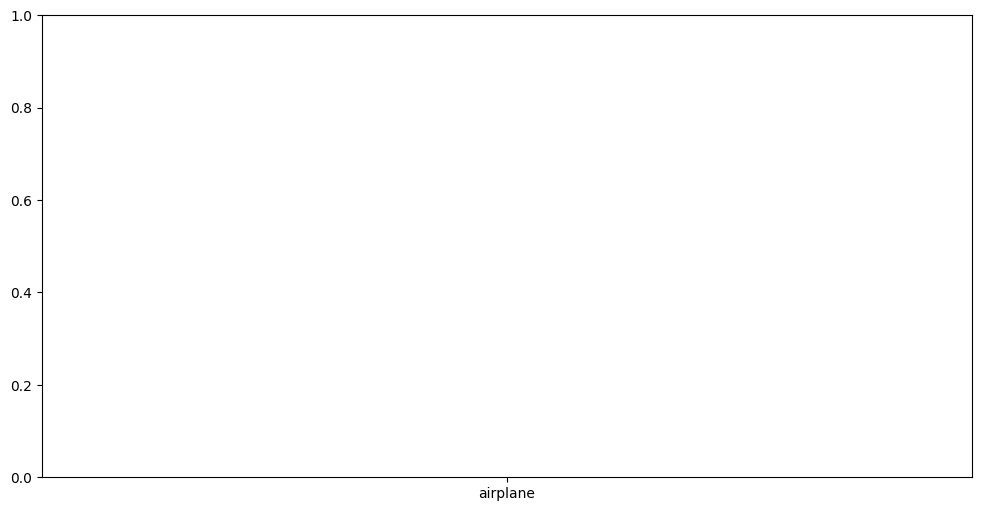

In [14]:
# 评估模型在各个类别上的性能
class_accuracies = evaluate_model_classes(model, X_test, y_test, CIFAR10_CLASSES)

# 绘制各类别准确率
plt.figure(figsize=(12, 6))
plt.bar(CIFAR10_CLASSES, class_accuracies)
plt.xlabel('类别')
plt.ylabel('准确率')
plt.title('模型在各个类别上的准确率')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## 9. 模型参数可视化

### 9.1 第一层权重可视化

第一层权重可以重塑为图像形状，直观地展示模型学习到的特征。

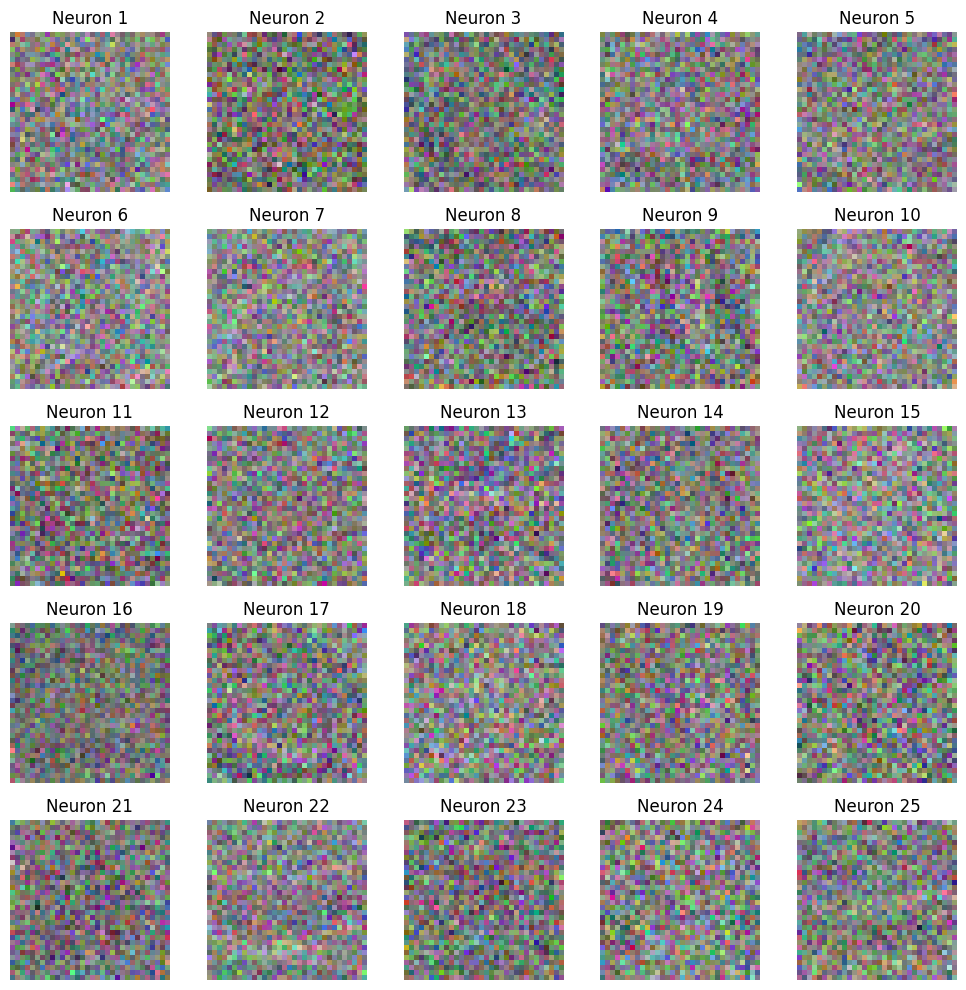

In [15]:
# 可视化第一层权重
visualize_weights(model, layer='W1', num_neurons=25)

### 9.2 各层权重分布可视化

通过观察各层权重的分布，可以了解模型参数的统计特性。

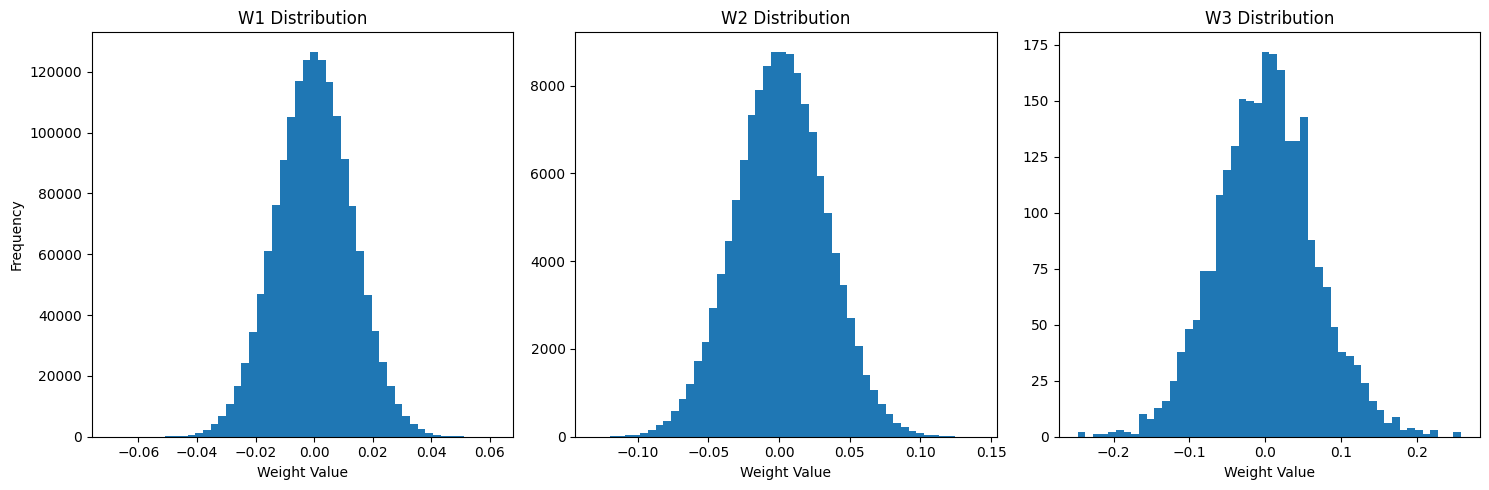

In [16]:
# 可视化各层权重分布
visualize_weight_distributions(model)

### 9.3 权重范数分析

C:\Users\90974\AppData\Local\Temp\ipykernel_6348\871158994.py:25: UserWarning: Glyph 33539 (\N{CJK UNIFIED IDEOGRAPH-8303}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\90974\AppData\Local\Temp\ipykernel_6348\871158994.py:25: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\90974\AppData\Local\Temp\ipykernel_6348\871158994.py:25: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\90974\AppData\Local\Temp\ipykernel_6348\871158994.py:25: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\90974\AppData\Local\Temp\ipykernel_6348\871158994.py:25: UserWarning: Glyph 31532 (\N{CJK UNIFIED IDEOGRAPH-7B2C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\90974\AppData\Local\Temp\ipykernel_6348\871158994.py:25: UserWarning: Glyph 19968 (\N{CJK UNIFIE

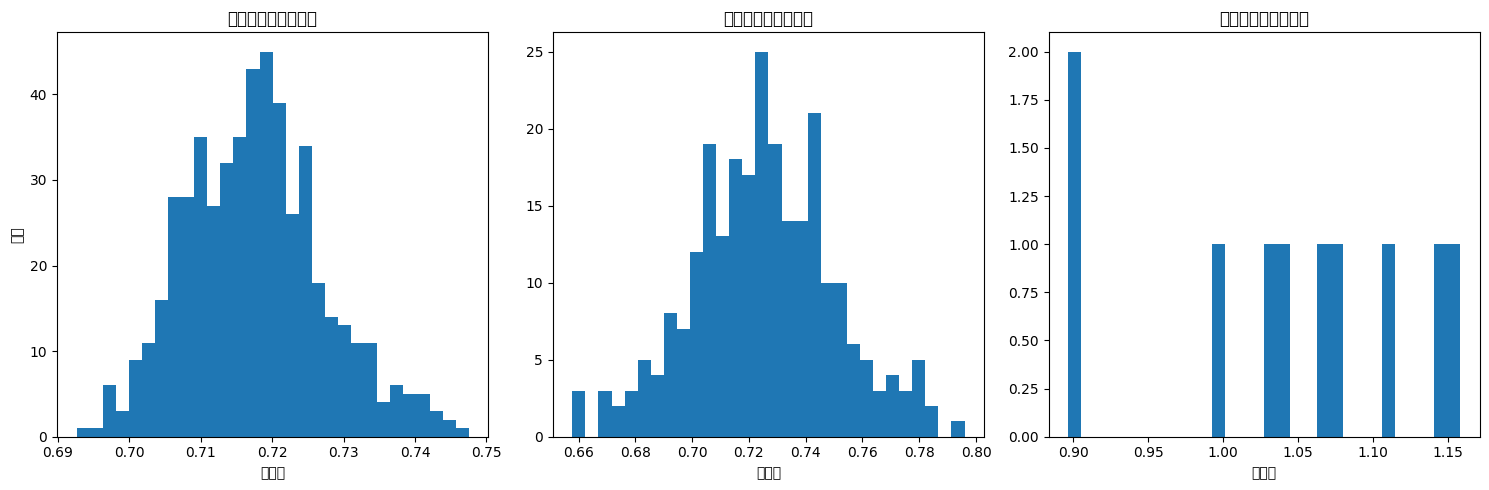

In [18]:
# 计算各层权重的范数
w1_norm = np.linalg.norm(model.params['W1'], axis=0)
w2_norm = np.linalg.norm(model.params['W2'], axis=0)
w3_norm = np.linalg.norm(model.params['W3'], axis=0)

# 绘制权重范数分布
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(w1_norm, bins=30)
plt.title('第一层权重范数分布')
plt.xlabel('范数值')
plt.ylabel('频数')

plt.subplot(1, 3, 2)
plt.hist(w2_norm, bins=30)
plt.title('第二层权重范数分布')
plt.xlabel('范数值')

plt.subplot(1, 3, 3)
plt.hist(w3_norm, bins=30)
plt.title('输出层权重范数分布')
plt.xlabel('范数值')

plt.tight_layout()
plt.show()

### 9.4 权重激活模式分析

In [19]:
# 分析第一层权重的激活模式
# 选择一些测试样本
sample_indices = np.random.choice(X_test.shape[0], 5)
samples = X_test[sample_indices]

# 计算第一层激活
z1 = np.dot(samples, model.params['W1']) + model.params['b1']
a1 = np.maximum(0, z1)  # ReLU激活

# 计算每个样本激活的神经元数量
active_neurons = (a1 > 0).sum(axis=1)

# 显示结果
for i, idx in enumerate(sample_indices):
    print(f'样本 {i+1} (类别: {CIFAR10_CLASSES[y_test[idx]]}): 激活了 {active_neurons[i]} 个神经元 (占比: {active_neurons[i]/model.hidden_size1:.2f})')

样本 1 (类别: cat): 激活了 261 个神经元 (占比: 0.51)
样本 2 (类别: truck): 激活了 257 个神经元 (占比: 0.50)
样本 3 (类别: bird): 激活了 267 个神经元 (占比: 0.52)
样本 4 (类别: deer): 激活了 250 个神经元 (占比: 0.49)
样本 5 (类别: frog): 激活了 240 个神经元 (占比: 0.47)


### 9.5 类别特定神经元分析

C:\Users\90974\AppData\Local\Temp\ipykernel_6348\1848230590.py:23: UserWarning: Glyph 31070 (\N{CJK UNIFIED IDEOGRAPH-795E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\90974\AppData\Local\Temp\ipykernel_6348\1848230590.py:23: UserWarning: Glyph 32463 (\N{CJK UNIFIED IDEOGRAPH-7ECF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\90974\AppData\Local\Temp\ipykernel_6348\1848230590.py:23: UserWarning: Glyph 20803 (\N{CJK UNIFIED IDEOGRAPH-5143}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\90974\AppData\Local\Temp\ipykernel_6348\1848230590.py:23: UserWarning: Glyph 32034 (\N{CJK UNIFIED IDEOGRAPH-7D22}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\90974\AppData\Local\Temp\ipykernel_6348\1848230590.py:23: UserWarning: Glyph 24341 (\N{CJK UNIFIED IDEOGRAPH-5F15}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\90974\AppData\Local\Temp\ipykernel_6348\1848230590.py:23: UserWarning: Glyph 26435 (\N{CJK 

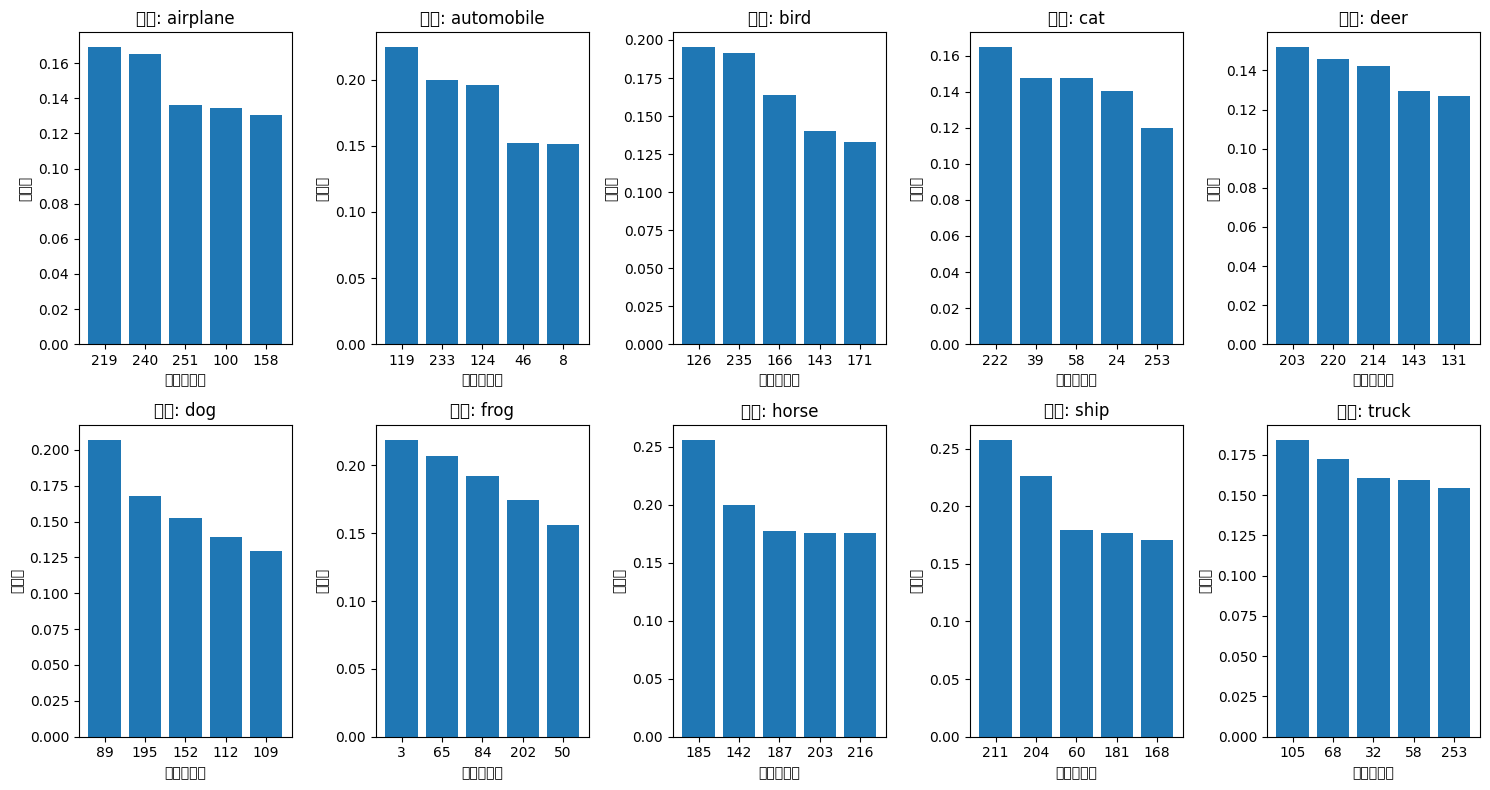

In [21]:
# 分析输出层权重，找出对每个类别最重要的隐藏层神经元
output_weights = model.params['W3']  # 形状为 (hidden_size2, output_size)

# 对于每个类别，找出权重最大的5个神经元
plt.figure(figsize=(15, 8))

for class_idx in range(10):
    # 获取该类别的权重
    class_weights = output_weights[:, class_idx]
    
    # 找出权重最大的5个神经元
    top_neurons = np.argsort(class_weights)[-5:][::-1]
    top_weights = class_weights[top_neurons]
    
    # 绘制结果
    plt.subplot(2, 5, class_idx + 1)
    plt.bar(range(5), top_weights)
    plt.title(f'类别: {CIFAR10_CLASSES[class_idx]}')
    plt.xlabel('神经元索引')
    plt.ylabel('权重值')
    plt.xticks(range(5), top_neurons)

plt.tight_layout()
plt.show()

## 10. 实验结论

通过本实验，我们成功实现了一个三层神经网络模型，并在CIFAR-10数据集上进行了训练和评估。主要结论如下：

1. **模型性能**：模型在测试集上达到了一定的准确率，但仍有提升空间。不同类别的识别准确率存在差异，这可能与类别之间的相似性有关。

2. **训练过程**：从损失曲线和准确率曲线可以看出，模型在训练过程中逐渐收敛，但在后期可能出现了过拟合现象。

3. **参数分析**：
   - 第一层权重可视化显示，模型学习到了一些基本的视觉特征，如边缘、纹理等。
   - 权重分布呈现出近似正态分布的特性，这与权重初始化方法和正则化效果有关。
   - 不同类别依赖于不同的隐藏层神经元，这反映了模型对不同类别特征的学习。

4. **改进方向**：
   - 增加网络深度和宽度，提高模型容量
   - 尝试不同的优化器和学习率调度策略
   - 引入更强的正则化方法，如Dropout
   - 使用数据增强技术扩充训练集